In [1]:
import sys
from pathlib import Path

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

In [3]:
from src import prepare_datasets, ModelTrainer, accuracy
from models.eight_layer_conv_net.architecture import EightLayerConvNet
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms

### Model 1: Eight Layer Conv Net

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6406 | val loss: 1.3951 | accuracy: 49.03%
Validation loss decreased (inf --> 1.3951). Saving model.
[epoch 02] train loss: 1.1887 | val loss: 1.1398 | accuracy: 58.56%
Validation loss decreased (1.3951 --> 1.1398). Saving model.
[epoch 03] train loss: 0.9973 | val loss: 1.4422 | accuracy: 52.03%
EarlyStopping counter: 1 out of 3
[epoch 04] train loss: 0.8957 | val loss: 1.1119 | accuracy: 61.65%
Validation loss decreased (1.1398 --> 1.1119). Saving model.
[epoch 05] train loss: 0.7049 | val loss: 0.6644 | accuracy: 77.97%
Validation loss decreased (1.1119 --> 0.6644). Saving model.
[epoch 06] train loss: 0.6136 | val loss: 0.6094 | accuracy: 79.68%
Validation loss decreased (0.6644 --> 0.6094). Saving model.
[epoch 07] train loss: 0.5680 | val loss: 0.5911 | accuracy: 80.60%
Validation loss decreased (0.6094 --> 0.5911). Saving model.
[epoch 08] tra

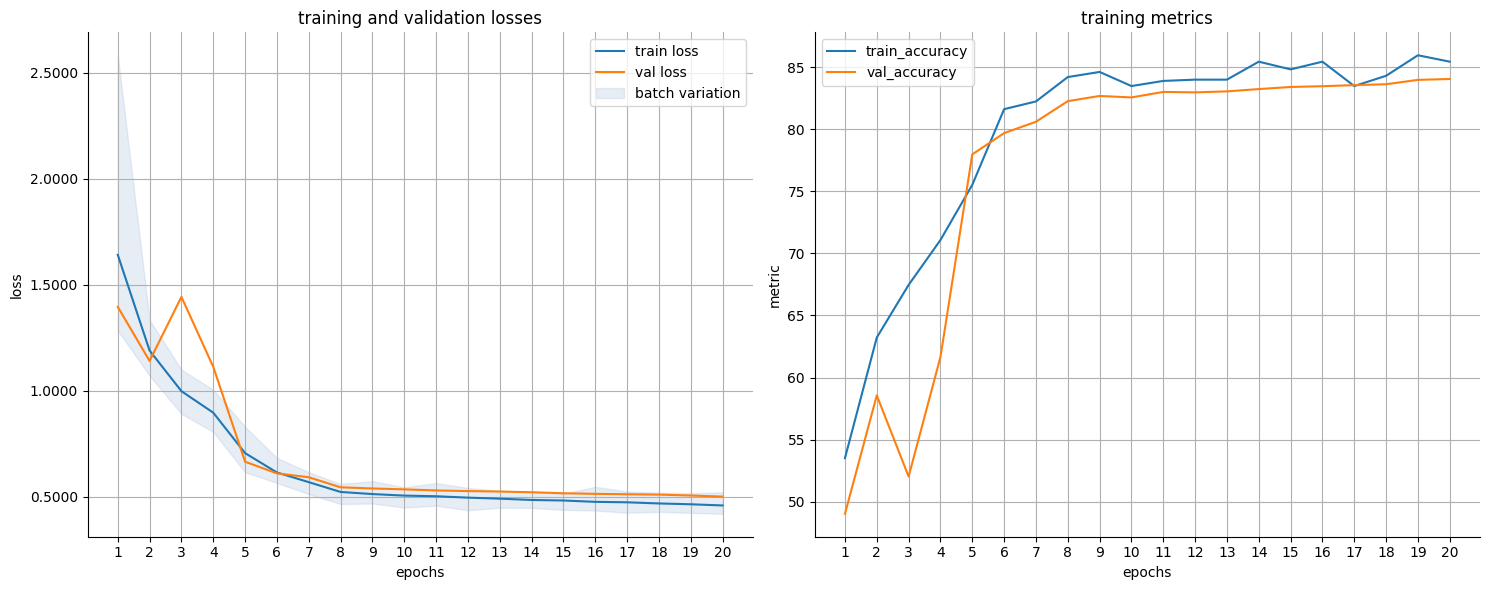

In [2]:
from src import prepare_datasets, ModelTrainer, accuracy
from models.eight_layer_conv_net.architecture import EightLayerConvNet
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

def train_model(model, model_name, num_epochs=200):
    optimizer = SGD(
        model.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=0.01,
    )
    
    scheduler = MultiStepLR(
        optimizer,
        milestones=[8, 13],
        gamma=0.1
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=3,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model1 = EightLayerConvNet()
trainer1 = train_model(model1, "EightLayerConvNet", num_epochs=20)

In [3]:
test_results_1 = trainer1.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation
Test Loss: 0.4924 | accuracy: 84.42


### Model 2: Eight Layer Conv Net Modified

Files already downloaded and verified
Files already downloaded and verified
Using FP16 (half precision) training
[epoch 01] train loss: 1.6384 | val loss: 1.3451 | accuracy: 51.02%
Validation loss decreased (inf --> 1.3451). Saving model.
[epoch 02] train loss: 1.1690 | val loss: 1.2275 | accuracy: 55.01%
Validation loss decreased (1.3451 --> 1.2275). Saving model.
[epoch 03] train loss: 0.9780 | val loss: 0.9980 | accuracy: 65.02%
Validation loss decreased (1.2275 --> 0.9980). Saving model.
[epoch 04] train loss: 0.8587 | val loss: 0.9696 | accuracy: 66.84%
Validation loss decreased (0.9980 --> 0.9696). Saving model.
[epoch 05] train loss: 0.7783 | val loss: 1.0523 | accuracy: 63.68%
EarlyStopping counter: 1 out of 5
[epoch 06] train loss: 0.6802 | val loss: 0.9124 | accuracy: 69.89%
Validation loss decreased (0.9696 --> 0.9124). Saving model.
[epoch 07] train loss: 0.6562 | val loss: 0.8471 | accuracy: 70.49%
Validation loss decreased (0.9124 --> 0.8471). Saving model.
[epoch 08] tra

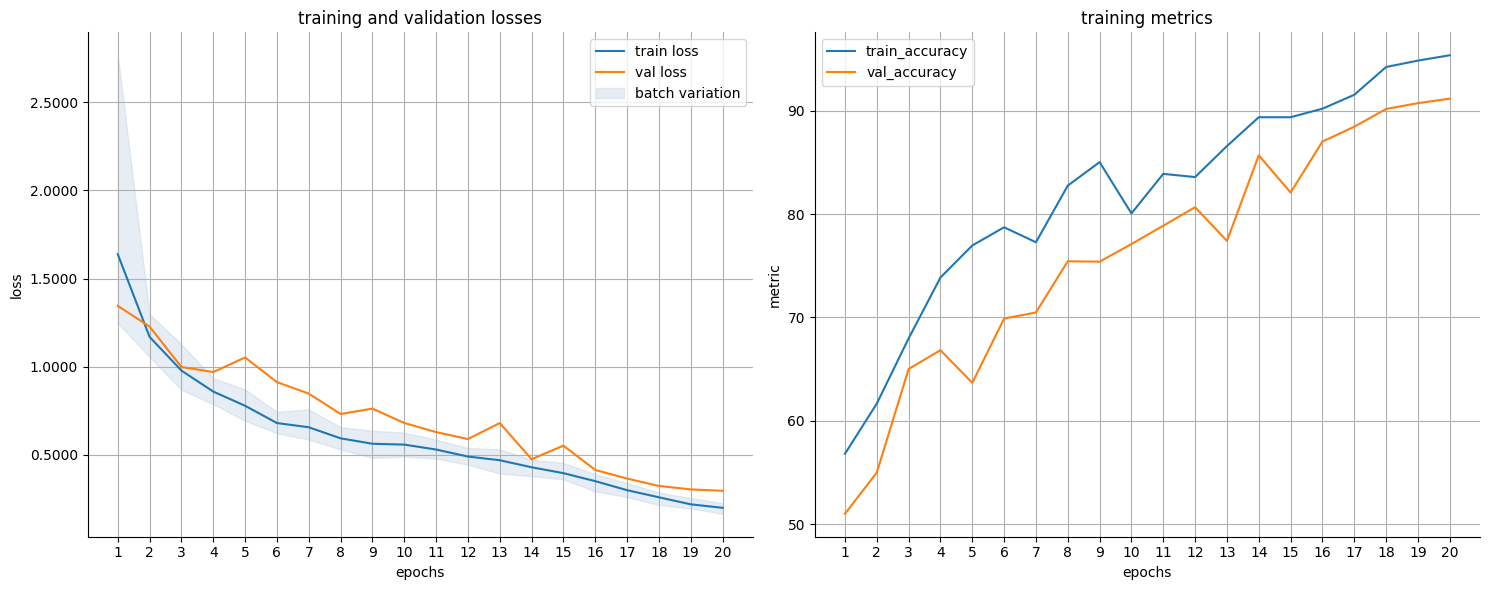

In [4]:
from models.mod_eight_layer_conv_net.architecture import ModEightLayerConvNet
from torch.optim.lr_scheduler import OneCycleLR
import math

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True
)

def train_model(model, model_name, num_epochs=200):

    max_lr = 0.1
    div_factor = 5          # controls initial LR: higher = lower start (max_lr/div_factor = 0.1/5 = 0.02)
    final_div_factor = 15   # controls decay speed: higher = faster decay (max_lr/final_div_factor = 0.1/15 ≈ 0.007)
    initial_lr = max_lr / div_factor
    
    # adjust warmup length based on absolute epochs, not percentage
    # absolute_warmup_epochs = 12
    # pct_start = absolute_warmup_epochs / num_epochs  # dynamically calculated
    pct_start = 0.23
   
    optimizer = SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        weight_decay=0.01,
    )

    # calculate total steps
    steps_per_epoch = math.ceil(len(trainset) / 1024)
    total_steps = steps_per_epoch * num_epochs

    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,                     # (1) Peak learning rate
        total_steps=total_steps,           # (2) Total number of training iterations
        pct_start=pct_start,               # (3) Percentage of training spent in warmup
        div_factor=div_factor,             # (4) Initial LR division factor  (Initial LR = max_lr/div_factor = 0.1/5 = 0.02)
        final_div_factor=final_div_factor, # (5) Final LR division factor    (Final LR = max_lr/final_div_factor = 0.1/15 ≈ 0.007)
        anneal_strategy='cos'              # (6) Type of annealing (default 'cos')
    )
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=1024,
        verbose=True,
        save_metrics=False,
        early_stopping_patience=5,
        early_stopping_delta=1e-4,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
        step_scheduler_batch=True,

    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model2 = ModEightLayerConvNet()
trainer2 = train_model(model2, "ModEightLayerConvNet", num_epochs=20)

In [5]:
test_results_2 = trainer2.evaluate_on_test(test_set=testset)


Loading Best Model for Test Evaluation


Test Loss: 0.3020 | accuracy: 90.88


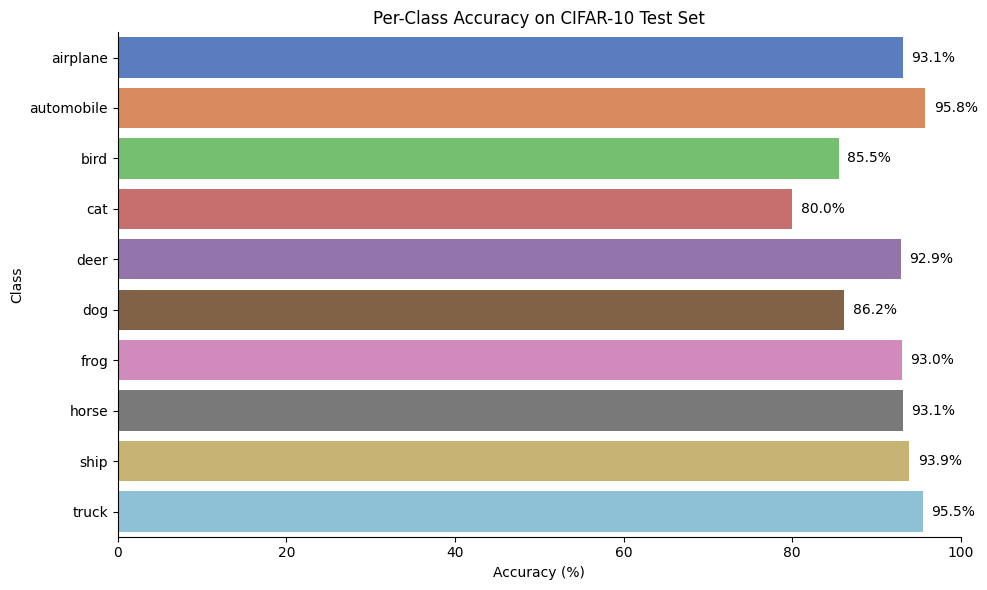

In [34]:
from src import MetricsPlotter
import numpy as np

predictions = test_results_2['predictions']
true_labels = test_results_2['true_labels']

# calculate per-class accuracy
class_correct = np.zeros(10)
class_total = np.zeros(10)
for i in range(len(true_labels)):
    label = true_labels[i]
    class_total[label] += 1
    if predictions[i] == label:
        class_correct[label] += 1

per_class_accuracy = (class_correct / class_total) * 100

# plot
plotter = MetricsPlotter()
ax = plotter.plot_class_accuracy(per_class_accuracy, testset.classes, dataset_name="CIFAR-10")

In [33]:
from importlib import reload
import src
import src.visualization
import src.visualization.plotting

# reload in correct order (from deepest to highest)
reload(src.visualization.plotting)
reload(src.visualization)
reload(src)

<module 'src' from '/home/gustaf/projects/deeplearning/deep_learning_tools/src/__init__.py'>

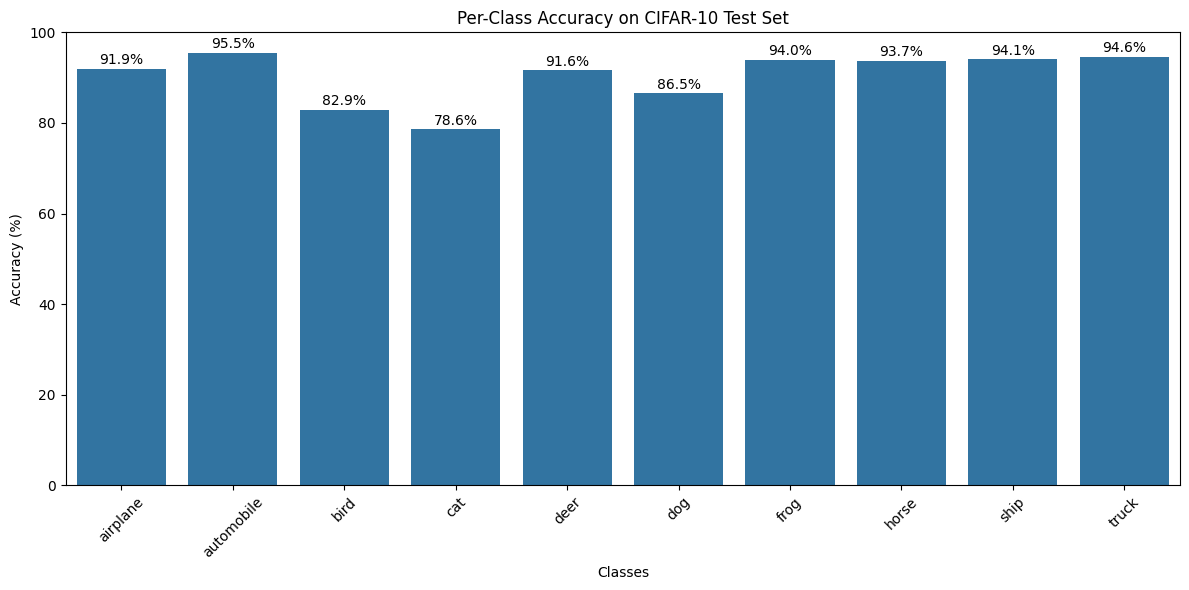


Per-class accuracy:
airplane: 91.9%
automobile: 95.5%
bird: 82.9%
cat: 78.6%
deer: 91.6%
dog: 86.5%
frog: 94.0%
horse: 93.7%
ship: 94.1%
truck: 94.6%


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

# set evaluation mode
trainer2.model.eval()

# ensure model is using the same precision type
trainer2.model = trainer2.model.float()  # convert model to float32
trainer2.model = trainer2.model.to(trainer2.device)  # ensure model is on correct device

# create test dataloader
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

# get all predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # ensure images are float32
        images = images.float().to(trainer2.device)
        outputs = trainer2.model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# calculate per-class accuracy
class_correct = np.zeros(10)
class_total = np.zeros(10)

for i in range(len(all_labels)):
    label = all_labels[i]
    class_total[label] += 1
    if all_preds[i] == label:
        class_correct[label] += 1

per_class_accuracy = (class_correct / class_total) * 100

# create visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=testset.classes, y=per_class_accuracy)
plt.title('Per-Class Accuracy on CIFAR-10 Test Set')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # set y-axis from 0 to 100%

# add percentage labels on top of each bar
for i, v in enumerate(per_class_accuracy):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

# print numerical results
print("\nPer-class accuracy:")
for i, (class_name, accuracy) in enumerate(zip(testset.classes, per_class_accuracy)):
    print(f"{class_name}: {accuracy:.1f}%")

### Bonus Model: Transfer Learning EfficientNet-B4

In [5]:
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=160, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_val = transforms.Compose([
    transforms.Resize(200),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset, valset, testset = prepare_datasets(
    dataset_name=dataset_name, 
    data_root=data_root,
    transform_train=transform_train,
    transform_val=transform_val,
    normalize=False,
    use_validation_split=True,
)

model3 = EfficientNet.from_pretrained('efficientnet-b4', num_classes=10)

optimizer = SGD(
    model3.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-6
)

scheduler = StepLR(
    optimizer,
    step_size=10,
    gamma=0.1
)

trainer3 = ModelTrainer(
    model=model3,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=32,
    verbose=True,
    save_metrics=False,
    early_stopping_patience=float('inf'),
    metrics=[accuracy],
    log_dir="logs/EfficientNet",
    logger_type="file"
)

trained_model3 = trainer3.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=2
)

Files already downloaded and verified
Files already downloaded and verified
Loaded pretrained weights for efficientnet-b4
Using FP16 (half precision) training

Training interrupted. Cleaning up...
Model state already saved as checkpoint.pt.
Training was manually interrupted.


In [ ]:
test_metrics = trainer3.evaluate_on_test(test_set=testset)